# Challenge 3: Artificial Neural Networks

<a target="_blank" href="https://colab.research.google.com/github/LucaPennella/Intro_to_ML_23-24/blob/main/challenges/challenge-three.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


Using Fully Connected Neural Networks and Convolutional Neural Networks, perform the following tasks on [this data set](https://pytorch.org/vision/stable/generated/torchvision.datasets.KMNIST.html#torchvision.datasets.KMNIST).
1. Data exploration.
2. For each architecture, tune the number of the hidden layers ($\le 3$), the optimizer, and some hyperparameters of your choice. How many tries to do is up to your discretion.
3. Summarise your results in a table and comment on them in the report.
4. For a model (not necessarily the best performing one), plot training loss vs testing loss and training accuracy vs testing accuracy, and comment on what you see.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as LA
import random
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from time import time

torch.manual_seed(0)

## 1. Data exploration

In [2]:
BATCH_SIZE = 64

data_transforms = transforms.ToTensor()

## TRAIN set
trainset = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=data_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
print(len(trainset))

## TEST set
testset = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=data_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)
print(len(testset))

60000
10000


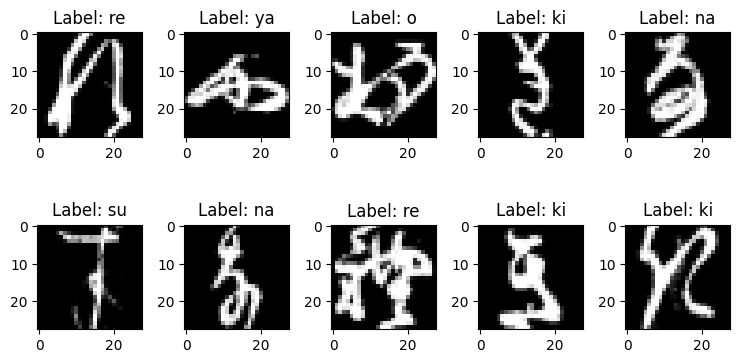

Classes: ['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo']


In [3]:
num_row = 2
num_col = 5

classes = trainset.classes

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col, 2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(trainset.data[i], cmap='gray')
    ax.set_title('Label: {}'.format(classes[trainset.targets[i]]))
plt.tight_layout()
plt.show()

print(f'Classes: {classes}')

In [ ]:
# printing data shapes
print("Single image dimensions:", trainset.data[0].shape)
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

## Model building

#### FULLY CONNECTED

In [ ]:
class FullyConnected_1(nn.Module):
    def __init__(self):
        super(FullyConnected_1, self).__init__()

        self.l1 = nn.Linear(28 * 28, 32 * 26 * 26)  # Input size: 28*28 (dimensione immagine KMNIST)
        self.l2 = nn.Linear(32 * 26 * 26, 128)
        self.l3 = nn.Linear(128, 10)


    def forward(self, x):
        # Flatten: BSx1x28x28 => BSx(28*28)
        x = x.view(x.size(0), -1)

        # BSx(28*28) => BSx128
        x = F.relu(self.l1(x))

        # BSx128 => BSx64
        x = F.relu(self.l2(x))

        # BSx64 => BSx10
        logits = self.l3(x)

        # Softmax computation
        out = F.softmax(logits, dim=1)

        return out

#### CONVOLUTIONAL

1 hidden layer

In [4]:
class Convolutional_1(nn.Module):
    def __init__(self):
        super(Convolutional_1, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)   # 28 - kernel_size +1 = 24
        # max-pooling 2x2: 24 / 2 = 12
        self.l1 = nn.Linear(32 * 12 * 12, 128)
        self.l2 = nn.Linear(128, 10)


    def forward(self, x):

        x = self.conv1(x)               # Convolution: BSx1x28x28 => BSx32x24x24
        x = F.relu(x)

        x = F.max_pool2d(x,2)           # Max-pooling 2x2 => BSx32x12x12

        x = x.flatten(start_dim = 1)    # flatten => BS x 4608

        x = self.l1(x)                  # Linear: BSx(32*12*12) => BSx128
        x = F.relu(x)

        logits = self.l2(x)             # Linear: BSx128 => BSx10

        # Softmax computation: ogni neurone in uscita avra un label assegnato; softmax indica la probabilita che appartenga effettivamente a quella classe
        out = F.softmax(logits, dim=1)

        return out

3 hidden layers

In [ ]:
class Convolutional_3(nn.Module):
    def __init__(self):
        super(Convolutional_3, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)       # 28 - kernel_size +1 = 24
        # max-pooling 2x2: 24 / 2 = 12
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3)     # 12 - kernel_size +1 = 10
        # max-pooling 2x2: 10 / 2 = 5
        self.l1 = nn.Linear(128 * 5 * 5, 256)
        self.l2 = nn.Linear(256, 64)
        self.l3 = nn.Linear(64, 10)


    def forward(self, x):

        x = self.conv1(x)               # Convolution: BSx1x28x28 => BSx32x24x24
        x = F.relu(x)

        x = F.max_pool2d(x,2)           # Max-pooling 2x2 => BSx32x12x12

        x = self.conv2(x)               # Convolution: BSx32x12x212 => BSx128x10x10
        x = F.relu(x)

        x = F.max_pool2d(x,2)           # Max-pooling 2x2 => BSx128x5x5

        x = x.flatten(start_dim = 1)    # flatten => BS x 3200

        x = self.l1(x)                  # Linear: BSx(128*5*5) => BSx256
        x = F.relu(x)

        x = self.l2(x)                  # Linear: BSx256 => BSx64
        x = F.relu(x)

        logits = self.l3(x)             # Linear: BSx64 => BSx10

        # Softmax computation: ogni neurone in uscita avra un label assegnato; softmax indica la probabilita che appartenga effettivamente a quella classe
        out = F.softmax(logits, dim=1)

        return out

#### Training cycle

In [5]:
def get_accuracy(logit, target):
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()


def compute_weight_norm(model):
    norm = 0.0
    for name, param in model.named_parameters():
      if "weight" in name:
        norm += torch.norm(param.data, p= 2)
    return norm.cpu().item()


def train_model(model, num_epochs, trainloader, criterion, optimizer, device):

    print(f'Training model: {model.__class__.__name__} with Loss function: {criterion} and Optimizer: {optimizer.__class__.__name__}\n')

    # Rich mac user
    # device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    model = model.to(device)

    losses = []
    accs = []

    norms = []

    for epoch in range(num_epochs):
        train_running_loss = 0.0
        train_acc = 0.0

        # Set the model to training mode
        model = model.train()
        start = time()
        ## training step
        for i, (images, labels) in enumerate(trainloader):

            images = images.to(device)
            labels = labels.to(device)

            ## forward + backprop + loss
            logits = model(images)
            loss = criterion(logits, labels)

            # Reset the gradients to zero
            optimizer.zero_grad()

            loss.backward()

            ## update model params
            optimizer.step()

            train_running_loss += loss.item()
            train_acc += get_accuracy(logits, labels)


        losses.append(train_running_loss / i)
        accs.append(train_acc/i)

        norms.append(compute_weight_norm(model))
        model.eval()
        print(f"\tEpoch: [{epoch+1}/{num_epochs}] | Loss: {train_running_loss / i:.4f} | Train Accuracy: {train_acc/i:.4f} | Time: {time()-start:.2f}")

    print('\n')
    return losses, accs, norms

In [ ]:
num_epochs = 10
num_models = 3*2    # 3 modelli, 2 ottimizzatori
#learning_rates = [0.001, 0.01, 0.1]
learning_rates = [0.00001]#, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 3]
criterion = nn.CrossEntropyLoss()

losses = []
accuracies = []
weight_norms = []
optimizer_names = ['SGD', 'Adam']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for lr in learning_rates:

    print('-'*90)
    print(f'Training with learning rate: {lr}')
    print(f'Using device: {device}' if device=='cpu' else f'Using device: {device} ({torch.cuda.get_device_name()})')
    print('-'*90)
    print()

    losses_lr = []
    accuracies_lr = []
    weight_norms_lr = []

    for model_index in range(0, num_models, 2):

        # devo re-instanziarli ad ogni ciclo, altrimenti il training non si resetta ma continua da dove aveva terminato quello precedente
        models = [FullyConnected_1(), FullyConnected_1(), Convolutional_1(), Convolutional_1(), Convolutional_3(), Convolutional_3()]

        loss_sgd, acc_sgd, W_sgd = train_model(models[model_index], num_epochs, trainloader, criterion, torch.optim.SGD(models[model_index].parameters(), lr=lr), device)
        loss_adam, acc_adam, W_adam = train_model(models[model_index+1], num_epochs, trainloader, criterion, torch.optim.Adam(models[model_index+1].parameters(), lr=lr), device)

        losses_lr.extend([loss_sgd, loss_adam])
        accuracies_lr.extend([acc_sgd, acc_adam])
        weight_norms_lr.extend([W_sgd, W_adam])

    losses.append(losses_lr)
    accuracies.append(accuracies_lr)
    weight_norms.append(weight_norms_lr)

    print()

In [ ]:
print(device)

## Tables
3. Summarise your results in a table and comment on them in the report.

In [ ]:
models_for_table = [[FullyConnected_1(), FullyConnected_1()], [Convolutional_1(), Convolutional_1()], [Convolutional_3(), Convolutional_3()]]
num_models = len(models_for_table)         # number of models: in this case, 3 (FullyConnected_1, Convolutional_1, Convolutional_3)
num_optimizers = len(optimizer_names)      # number of optimizers: in this case, 2 (SGD and Adam)
num_rows = num_epochs * num_models * num_optimizers

pd.set_option('display.max_columns', None)  # To display all columns
pd.set_option('display.max_rows', None)     # To display all rows

for lr_index, lr in enumerate(learning_rates):
    
    print(f'\nLearning rate: {lr}')

    table = pd.DataFrame({'Model' : [models_for_table[i][0].__class__.__name__ for i in range(num_models) for j in range(num_epochs*num_optimizers)],
            'Optimizer' : [optimizer_names[i] for k in range(num_models) for i in range(num_optimizers) for j in range(num_epochs)],
            'Epoch': [i % (num_epochs) + 1 for i in range(num_rows)],
            'Loss': [losses[lr_index][i][j] for i in range(num_models*num_optimizers) for j in range(num_epochs)],
            'Accuracy (train)': [accuracies[lr_index][i][j] for i in range(num_models*num_optimizers) for j in range(num_epochs)],
            })

    separator = pd.DataFrame({'Model' : ['---'],
            'Optimizer' : ['---'],
            'Epoch': ['---'],
            'Loss': ['---'],
            'Accuracy (train)': ['---'],
            })

    for i in range(num_optimizers*num_epochs, num_rows, num_optimizers*num_epochs+1):
        table = pd.concat([table.iloc[:i], separator, table.iloc[i:]]).reset_index(drop=True)

    print(table)
    print('-'*64)

## RIASSUNTO TABELLE
- I learning rate 5 e 10 fanno cacare sempre, possiamo toglierli
- Convolutional_3 SGD fa sempre cacare, si blocca su accuracy 10
- SGD con lr=0.1: Convolutional_3
- SGD con lr=0.5: Convolutional_1
- SGD con lr=1:   FullyConnected_1
- Tutti gli Adam con lr >= 0.01 si bloccano su accuracy 10 (a volte peggiorando)
- Adam con lr=0.0001: FullyConnected_1 (di parecchio)
- Adam con lr=0.001:  Convolutional_1


## Plotting
4. For a model (not necessarily the best performing one), plot training loss vs testing loss and training accuracy vs testing accuracy, and comment on what you see.

In [24]:
model = Convolutional_1()
num_epochs = 10
learning_rate = 0.5

criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

loss, accuracies, W = train_model(model, num_epochs, trainloader, criterion, optimizer, device)

Training model: Convolutional_1 with Loss function: CrossEntropyLoss() and Optimizer: SGD

	Epoch: [1/10] | Loss: 1.6986 | Train Accuracy: 76.9644 | Time: 4.68
	Epoch: [2/10] | Loss: 1.5742 | Train Accuracy: 89.2759 | Time: 4.60
	Epoch: [3/10] | Loss: 1.5391 | Train Accuracy: 92.7328 | Time: 4.58
	Epoch: [4/10] | Loss: 1.5246 | Train Accuracy: 94.1219 | Time: 4.62
	Epoch: [5/10] | Loss: 1.4986 | Train Accuracy: 96.6999 | Time: 4.70
	Epoch: [6/10] | Loss: 1.4925 | Train Accuracy: 97.2735 | Time: 4.71
	Epoch: [7/10] | Loss: 1.4823 | Train Accuracy: 98.2908 | Time: 4.58
	Epoch: [8/10] | Loss: 1.4783 | Train Accuracy: 98.6776 | Time: 4.69
	Epoch: [9/10] | Loss: 1.4759 | Train Accuracy: 98.8744 | Time: 4.61
	Epoch: [10/10] | Loss: 1.4745 | Train Accuracy: 99.0011 | Time: 4.75




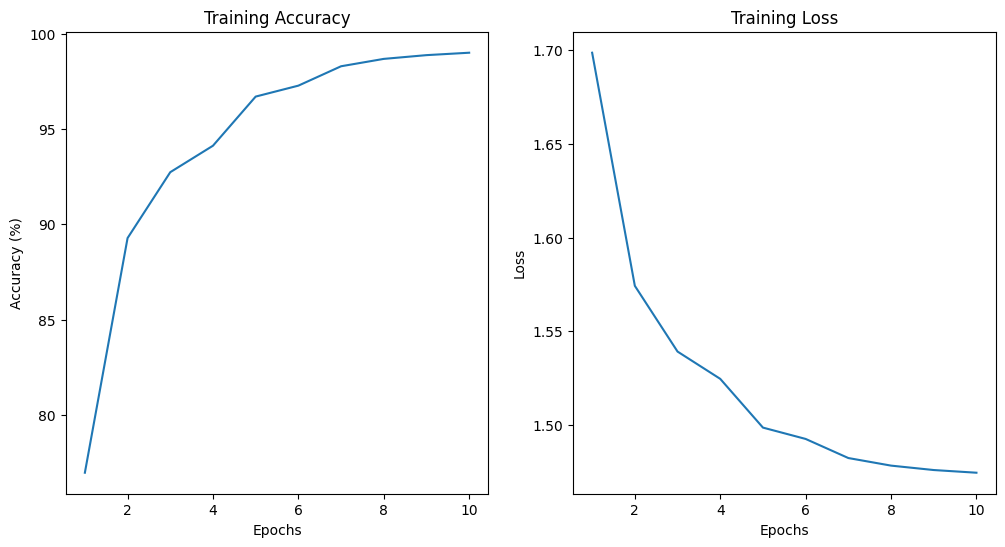

In [25]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(1, num_epochs+1), accuracies)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Training Accuracy')

ax2.plot(range(1, num_epochs+1), loss)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Training Loss')

# plt.tight_layout()
plt.show()

In [30]:
def cacca(model):
    test_running_acc = 0.0
    test_running_loss = 0.0
    test_accuracy = []
    test_loss = []
    for i, (images, labels) in enumerate(testloader, 0):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_running_loss += loss.item()/(len(testloader) - 1)
        test_running_acc += get_accuracy(outputs, labels)/(len(testloader) - 1)

        test_accuracy += [test_running_acc]
        test_loss += [test_running_loss]

    print(f"Test Accuracy: {test_running_acc:.4f}")
    print(f"Test Loss: {test_running_loss:.4f}")

    return test_accuracy, test_loss

In [32]:
# VA INSERITO IL MODELLO CHE SCEGLIAMO
model = Convolutional_1()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.5
criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for _ in range(5):
    
    num_epochs = 2
    loss, accuracies, W = train_model(model, num_epochs, trainloader, criterion, optimizer, device)
    test_accuracy, test_loss = cacca(model)

Training model: Convolutional_1 with Loss function: CrossEntropyLoss() and Optimizer: SGD

	Epoch: [1/2] | Loss: 1.6883 | Train Accuracy: 77.9849 | Time: 4.66
	Epoch: [2/2] | Loss: 1.5747 | Train Accuracy: 89.2526 | Time: 4.78


Test Accuracy: 81.1999
Test Loss: 1.6690
Training model: Convolutional_1 with Loss function: CrossEntropyLoss() and Optimizer: SGD

	Epoch: [1/2] | Loss: 1.5408 | Train Accuracy: 92.5193 | Time: 4.85
	Epoch: [2/2] | Loss: 1.5299 | Train Accuracy: 93.4949 | Time: 4.73


Test Accuracy: 84.2949
Test Loss: 1.6355
Training model: Convolutional_1 with Loss function: CrossEntropyLoss() and Optimizer: SGD

	Epoch: [1/2] | Loss: 1.5146 | Train Accuracy: 95.0690 | Time: 4.75
	Epoch: [2/2] | Loss: 1.4947 | Train Accuracy: 97.0401 | Time: 4.77


Test Accuracy: 91.2760
Test Loss: 1.5666
Training model: Convolutional_1 with Loss function: CrossEntropyLoss() and Optimizer: SGD

	Epoch: [1/2] | Loss: 1.4908 | Train Accuracy: 97.4486 | Time: 4.74
	Epoch: [2/2] | Loss: 1.4879 | 

In [34]:
print(test_accuracy)

[0.5709134615384616, 1.1117788461538463, 1.7127403846153846, 2.2736378205128203, 2.8745993589743586, 3.415464743589743, 4.036458333333333, 4.637419871794871, 5.218349358974359, 5.78926282051282, 6.380208333333333, 6.921073717948717, 7.491987179487179, 8.112980769230768, 8.743990384615383, 9.32491987179487, 9.915865384615383, 10.526842948717947, 11.11778846153846, 11.718749999999998, 12.299679487179485, 12.91065705128205, 13.511618589743588, 14.1025641025641, 14.653445512820511, 15.25440705128205, 15.80528846153846, 16.38621794871795, 16.95713141025641, 17.508012820512818, 18.12900641025641, 18.669871794871792, 19.2207532051282, 19.79166666666666, 20.372596153846146, 20.943509615384606, 21.534455128205117, 22.135416666666657, 22.726362179487168, 23.307291666666657, 23.86818910256409, 24.46915064102563, 25.050080128205117, 25.651041666666657, 26.231971153846146, 26.832932692307686, 27.413862179487175, 28.02483974358974, 28.5957532051282, 29.216746794871792, 29.837740384615383, 30.4286858

ValueError: x and y must have same first dimension, but have shapes (2,) and (157,)

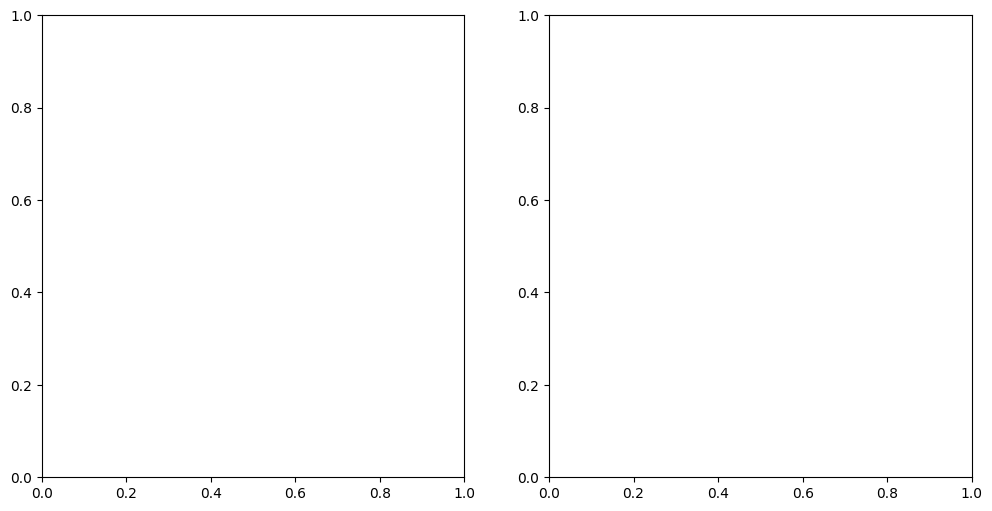

In [33]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(1,num_epochs+1), test_accuracy)
ax1.set_xlabel('Number of images')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Test Accuracy')

ax2.plot(range(1,num_epochs+1), test_loss)
ax2.set_xlabel('Number of images')
ax2.set_ylabel('Loss')
ax2.set_title('Test Loss')

# plt.tight_layout()
plt.show()

In [ ]:
'''# Number of times the whole (training) dataset is used for training
model = Convolutional_3()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


_, acc_adam, W_adam, device = train_model(model, num_epochs, trainloader, criterion, optimizer, learning_rate)'''

In [ ]:
'''test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels)

print(f"Test Accuracy: {test_acc/i:.4f}")'''

In [ ]:
'''model = FullyConnected()
num_epochs = 5
learning_rate = 0.001

criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

_, acc_SGD, W_SGD = train_model(model, num_epochs, trainloader, criterion, optimizer)'''

In [ ]:
'''test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_batch_accuracy(outputs, labels)

print(f"Test Accuracy: {test_acc/i:.4f}")'''